Mount Google Drive

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Read Dataset from Drive

In [ ]:
# prompt: read DDSM_Dataset folder from drive

import os

# Get the path to the DDSM_Dataset folder on Google Drive
ddsm_dataset_path = "/content/drive/My Drive/DDSM_Dataset"

# Change the current working directory to the DDSM_Dataset folder
os.chdir(ddsm_dataset_path)

# List the files and folders in the DDSM_Dataset folder
files_and_folders = os.listdir()

# Print the files and folders
print(files_and_folders)

['Malignant_Masses', 'Benign_Masses']


Resize all images into 255*255

In [ ]:
# prompt: resize all images present DDSM_Dataset

from PIL import Image

for filename in files_and_folders:
  if filename.endswith(".jpg"):
    img = Image.open(filename)
    img_resized = img.resize((255, 255))
    img_resized.save(filename)


Normalize the resized images

In [ ]:
# prompt: Normalize the resized images

import cv2

# Loop through all files in the current directory
for filename in files_and_folders:
  # Check if the file is a JPG image
  if filename.endswith(".jpg"):
    # Read the image using OpenCV
    img = cv2.imread(filename)

    # Normalize the image
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Save the normalized image
    cv2.imwrite(filename, img_normalized)


Convert all resized images into numpy array

In [ ]:
# prompt: convert all resized images into numpy array

import numpy as np
import cv2

# Initialize an empty list to store the numpy arrays
numpy_arrays = []

# Loop through all files in the current directory
for filename in files_and_folders:
  # Check if the file is a JPG image
  if filename.endswith(".jpg"):
    # Read the image using OpenCV
    img = cv2.imread(filename)

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Append the numpy array to the list
    numpy_arrays.append(img_array)

# Convert the list of numpy arrays to a single numpy array
numpy_arrays = np.array(numpy_arrays)


1. Setup and Preparation

In [ ]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 1.4 MB/s eta 0:00:00


In [ ]:
!pip install tensorflow

Loading,preprocessing and Splitting image data

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
from tensorflow.keras.utils import to_categorical
base_path = '/content/drive/MyDrive/DDSM_Dataset/'
benign_path = os.path.join(base_path, 'Benign_Masses')
malignant_path = os.path.join(base_path, 'Malignant_Masses')

# Load images and labels
def load_images_from_folder(folder, label, size=(255, 255)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            labels.append(label)
    return images, labels

benign_images, benign_labels = load_images_from_folder(benign_path, 0)  # 0 for benign
malignant_images, malignant_labels = load_images_from_folder(malignant_path, 1)  # 1 for malignant

# Combine and split dataset
images = benign_images + malignant_images
labels = benign_labels + malignant_labels
images = np.array(images)
labels = np.array(labels)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Import Libraries:

In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
from tensorflow.keras.utils import to_categorical

Reshaping

In [ ]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

Feature Selection and Classification Using Genetic Algorithm with Random
Forest

In [ ]:
# Initialize DEAP
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

# Create fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Setup DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train_flat.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def eval_individual(individual):
    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if not selected_features:
        return 0,

    X_train_sel = X_train_flat[:, selected_features]
    X_test_sel = X_test_flat[:, selected_features]

    clf = make_pipeline(StandardScaler(), RandomForestClassifier())
    clf.fit(X_train_sel, y_train)
    y_pred = clf.predict(X_test_sel)

    return accuracy_score(y_test, y_pred),

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("map", map)

def main():
    population = toolbox.population(n=50)
    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=10, verbose=True)
    best_ind = tools.selBest(population, 1)[0]
    print(f"Best individual: {best_ind}")
    accuracy = eval_individual(best_ind)[0]
    print(f"Accuracy: {accuracy}")
    return best_ind

if __name__ == "__main__":
    best_ind = main()

     # Debugging prints
    print("Best individual found by GA:", best_ind)
    best_features = [i for i in range(len(best_ind)) if best_ind[i] == 1]
    print("Selected features:", best_features)

    X_train_best = X_train_flat[:, best_features]
    X_test_best = X_test_flat[:, best_features]
    X_val_best = X_val_flat[:, best_features]

    # Train Random Forest on selected features
    clf = make_pipeline(StandardScaler(), RandomForestClassifier())
    clf.fit(X_train_best, y_train)

    # Evaluate model
    y_pred = clf.predict(X_test_best)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {test_accuracy}")


    # Validate model
    y_val_pred = clf.predict(X_val_best)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    print(f"Validation Accuracy: {val_accuracy}")

gen	nevals
0  	50    
1  	24    
2  	27    
3  	29    
4  	31    
5  	33    
6  	28    
7  	31    
8  	22    
9  	26    
10 	37    
Best individual: [-0.2889051160120219, 0.25580944751393236, 1.8670777100846325, -0.22597044896298707, 0.6287416987308059, -0.20527601667459355, 0.8943607367969075, -0.7494332080596893, -0.3218781322257733, 2.3140275281644693, -0.34114101450715417, 1.3850313843314486, 2.205804215424393, -1.0345174219473494, 1.8106393496928495, 1.0286381973313403, 2.9471009583012715, 1.0794208695934415, 1.109923752705287, 0.45117295844836525, 0.016833385039067603, 1.0430061663868986, -0.3520856092153861, 0.650271654872938, -1.8254578115077658, -1.5097723301965944, 0.15974668621842064, 0.19007710141737122, 1.398745783552471, 1.4234327635962114, -1.3858699953164118, 0.07761594950917262, 0.8494354756851099, -0.2111403762432583, 1.9364008852975372, 0.6952166300425012, 0.8928291011532032, 0.865082032761646, 0.13657293417048594, -0.2500834466879359, -0.031897325088726614, 0.800924

Printing accuracy,precision,recall and F1-score where the model trained by Genetic algorithm

In [ ]:
# prompt: give accuracy,precision,recall and F1-score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# ... (Your existing code) ...

# Evaluate model
y_pred = clf.predict(X_test_best)
test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred)

print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-score: {test_f1}")

# Validate model
y_val_pred = clf.predict(X_val_best)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {val_accuracy}")
print(f"Validation Precision: {val_precision}")
print(f"Validation Recall: {val_recall}")
print(f"Validation F1-score: {val_f1}")

Test Accuracy: 0.9788119561104806
Test Precision: 0.9775967413441955
Test Recall: 0.9842788790157211
Test F1-score: 0.9809264305177111
Validation Accuracy: 0.9776768823306848
Validation Precision: 0.9783216783216783
Validation Recall: 0.9803784162578837
Validation F1-score: 0.9793489674483724


In [ ]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Load images and labels from the dataset
def load_images_from_folder(folder, label, size=(255, 255)):
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            labels.append(label)
    return images, labels

# Paths to benign and malignant datasets
benign_path = '/content/drive/MyDrive/DDSM_Dataset/Benign_Masses'
malignant_path = '/content/drive/MyDrive/DDSM_Dataset/Malignant_Masses'

benign_images, benign_labels = load_images_from_folder(benign_path, 0)  # 0 for benign
malignant_images, malignant_labels = load_images_from_folder(malignant_path, 1)  # 1 for malignant

# Combine and split the dataset
images = np.array(benign_images + malignant_images)
labels = np.array(benign_labels + malignant_labels)

# Normalize images
images = images / 255.0

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Convert labels to categorical (one-hot encoding)
y_train_cat = to_categorical(y_train, 2)  # 2 classes: benign and malignant
y_test_cat = to_categorical(y_test, 2)

# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 output neurons for benign/malignant
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_cat, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {test_accuracy}")

# Save the trained model
model.save('/content/drive/MyDrive/classification_model.h5')

Epoch 1/10
265/265 [==============================] - 157s 588ms/step - loss: 0.1843 - accuracy: 0.9240 - val_loss: 0.0135 - val_accuracy: 0.9953
Epoch 2/10
265/265 [==============================] - 151s 569ms/step - loss: 0.0427 - accuracy: 0.9870 - val_loss: 0.0158 - val_accuracy: 0.9939
Epoch 3/10
265/265 [==============================] - 154s 580ms/step - loss: 0.0317 - accuracy: 0.9898 - val_loss: 0.0074 - val_accuracy: 0.9972
Epoch 4/10
265/265 [==============================] - 153s 576ms/step - loss: 0.0252 - accuracy: 0.9911 - val_loss: 0.0112 - val_accuracy: 0.9967
Epoch 5/10
265/265 [==============================] - 151s 571ms/step - loss: 0.0128 - accuracy: 0.9957 - val_loss: 0.0105 - val_accuracy: 0.9967
Epoch 6/10
265/265 [==============================] - 151s 570ms/step - loss: 0.0184 - accuracy: 0.9944 - val_loss: 0.0079 - val_accuracy: 0.9967
Epoch 7/10
265/265 [==============================] - 151s 569ms/step - loss: 0.0214 - accuracy: 0.9937 - val_loss: 0.0103 -

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 38ms/step


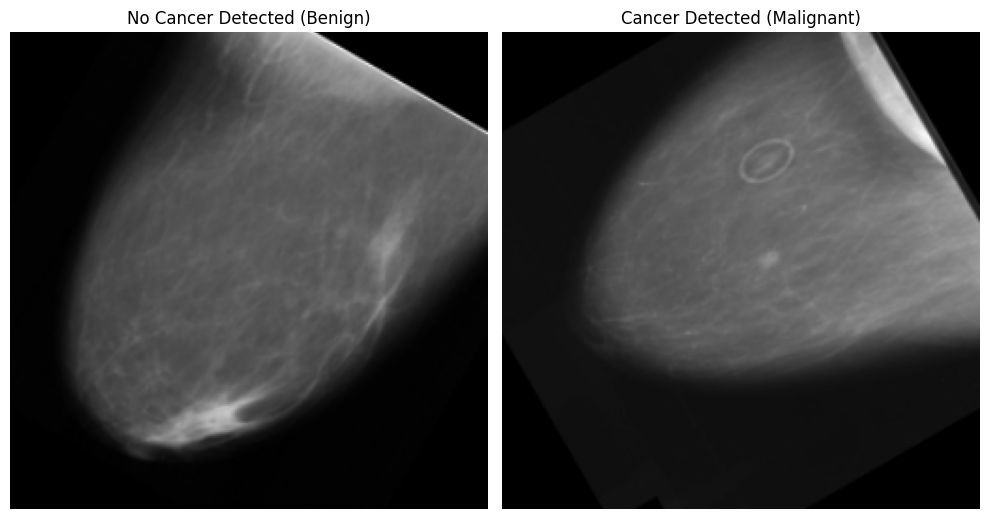

In [ ]:
import numpy as np
import cv2
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load the trained classification model
model = load_model('/content/drive/MyDrive/classification_model.h5')

# Function to preprocess the image for prediction
def preprocess_image(image_path, size=(255, 255)):
    img = cv2.imread(image_path)  # Read the image
    img_resized = cv2.resize(img, size)  # Resize to match model input size (255x255 in this case)
    img_normalized = img_resized / 255.0  # Normalize the pixel values
    img_expanded = np.expand_dims(img_normalized, axis=0)  # Add batch dimension
    return img_expanded, img_resized  # Also return resized image for display

# Function to predict if the image contains cancer cells
def predict_cancer(image_path, model):
    # Preprocess the image
    processed_image, resized_image = preprocess_image(image_path)

    # Make prediction
    prediction = model.predict(processed_image)

    # Get the predicted class (0: no cancer, 1: cancer)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Map predicted class to label
    if predicted_class == 0:
        label = 'No Cancer Detected (Benign)'
    else:
        label = 'Cancer Detected (Malignant)'

    return resized_image, label

# List of image paths
test_image_paths = [
    '/content/drive/MyDrive/DDSM_Dataset/Benign_Masses/D1_A_1177_1.RIGHT_CC (6).png',
    '/content/drive/MyDrive/DDSM_Dataset/Malignant_Masses/D1_A_1010_1.RIGHT_CC (4).png',
]

# Number of images
num_images = len(test_image_paths)

# Set up plot grid
fig, axes = plt.subplots(1, num_images, figsize=(10, 10))

# Predict and plot each image
for i, image_path in enumerate(test_image_paths):
    # Get the resized image and label prediction
    resized_image, label = predict_cancer(image_path, model)

    # Plot the image in the corresponding subplot
    axes[i].imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(label)
    axes[i].axis('off')  # Hide axes

# Display the full plot
plt.tight_layout()
plt.show()

Training with light model:Mobilenet

In [ ]:
# prompt: apply mobilenet model

from google.colab import drive
import os
from PIL import Image
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestCblassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# Mount Google Drive

drive.mount('/content/drive')
# Read Dataset from Drive


# Get the path to the DDSM_Dataset folder on Google Drive
ddsm_dataset_path = "/content/drive/My Drive/DDSM_Dataset"

# Change the current working directory to the DDSM_Dataset folder
os.chdir(ddsm_dataset_path)

# List the files and folders in the DDSM_Dataset folder
files_and_folders = os.listdir()

# Print the files and folders
print(files_and_folders)
# Resize all images into 255*255


for filename in files_and_folders:
  if filename.endswith(".jpg"):
    img = Image.open(filename)
    img_resized = img.resize((255, 255))
    img_resized.save(filename)

# Normalize the resized images


# Loop through all files in the current directory
for filename in files_and_folders:
  # Check if the file is a JPG image
  if filename.endswith(".jpg"):
    # Read the image using OpenCV
    img = cv2.imread(filename)

    # Normalize the image
    img_normalized = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX)

    # Save the normalized image
    cv2.imwrite(filename, img_normalized)

# Convert all resized images into numpy array


# Initialize an empty list to store the numpy arrays
numpy_arrays = []

# Loop through all files in the current directory
for filename in files_and_folders:
  # Check if the file is a JPG image
  if filename.endswith(".jpg"):
    # Read the image using OpenCV
    img = cv2.imread(filename)

    # Convert the image to a numpy array
    img_array = np.array(img)

    # Append the numpy array to the list
    numpy_arrays.append(img_array)

# Convert the list of numpy arrays to a single numpy array
numpy_arrays = np.array(numpy_arrays)

# 1. Setup and Preparation
!pip install deap
!pip install tensorflow
# Loading,preprocessing and Splitting image data
base_path = '/content/drive/MyDrive/DDSM_Dataset/'
benign_path = os.path.join(base_path, 'Benign_Masses')
malignant_path = os.path.join(base_path, 'Malignant_Masses')

# Load images and labels
def load_images_from_folder(folder, label, size=(224, 224)): # Resize to MobileNet input size
    images = []
    labels = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.resize(img, size)
            images.append(img)
            labels.append(label)
    return images, labels

benign_images, benign_labels = load_images_from_folder(benign_path, 0)  # 0 for benign
malignant_images, malignant_labels = load_images_from_folder(malignant_path, 1)  # 1 for malignant

# Combine and split dataset
images = benign_images + malignant_images
labels = benign_labels + malignant_labels
images = np.array(images)
labels = np.array(labels)

X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Preprocess data for MobileNet (scaling and one-hot encoding)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_val = X_val.astype('float32') / 255.0
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)

# Load MobileNet model (without top layers)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: benign and malignant

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model layers (optional, for transfer learning)
# for layer in base_model.layers:
#     layer.trainable = False

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Malignant_Masses', 'Benign_Masses']
9406464/9406464 [==============================] - 0s 0us/step
Epoch 1/10
248/248 [==============================] - 227s 864ms/step - loss: 0.0560 - accuracy: 0.9811 - val_loss: 17.8270 - val_accuracy: 0.5691
Epoch 2/10
248/248 [==============================] - 205s 825ms/step - loss: 0.0457 - accuracy: 0.9893 - val_loss: 15.0182 - val_accuracy: 0.5452
Epoch 3/10
248/248 [==============================] - 203s 820ms/step - loss: 0.0112 - accuracy: 0.9972 - val_loss: 21.6515 - val_accuracy: 0.5399
Epoch 4/10
248/248 [==============================] - 201s 811ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 21.2597 - val_accuracy: 0.5494
Epoch 5/10
248/248 [==============================] - 196s 792ms/step - loss: 0.0222 - accuracy: 0.9945 - val_loss: 11.7461 - val_accuracy: 0.4608
Epoch 6/10
248/248 [===============

In [ ]:
# prompt: apply ShuffleNet model
!pip install efficientnet
from efficientnet.tfkeras import EfficientNetB0 as ShuffleNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load ShuffleNet model (without top layers)
base_model = ShuffleNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)  # 2 classes: benign and malignant

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 861.6 kB/s eta 0:00:00
16804768/16804768 [==============================] - 0s 0us/step
Epoch 1/10
248/248 [==============================] - 330s 1s/step - loss: 0.0380 - accuracy: 0.9857 - val_loss: 0.0689 - val_accuracy: 0.9777
Epoch 2/10
248/248 [==============================] - 283s 1s/step - loss: 0.0199 - accuracy: 0.9953 - val_loss: 0.0351 - val_accuracy: 0.9905
Epoch 3/10
248/248 [==============================] - 290s 1s/step - loss: 0.0190 - accuracy: 0.9955 - val_loss: 0.0048 - val_accuracy: 0.9989
Epoch 4/10
248/248 [==============================] - 288s 1s/step - loss: 0.0018 - accuracy: 0.9997 - val_loss: 4.4347e-05 - val_accuracy: 1.0000
Epoch 5/10
248/248 [==============================] - 286s 1s/step - loss: 1.4314e-04 - accuracy: 1.0000 - val_loss: 6.1748e-06 - val_accuracy: 1.0000
Epoch 6/10
248/248 [==============================] - 279s 1s/step - loss: 6.5357e-04 - accuracy: 0.9999 - val_loss: 5.9956e-06 

Applying Regularization for shufflenet model

In [ ]:
# prompt: apply regularization that overcomes overfitting above model(shufflenet model) and print precision,recall,F1-score

from tensorflow.keras import regularizers

# Load ShuffleNet model (without top layers)
base_model = ShuffleNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom classification layers with L2 regularization
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)  # Add L2 regularization
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Predict probabilities for test set
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Convert one-hot encoded y_test back to class labels
y_test_labels = np.argmax(y_test, axis=1)

# Calculate precision, recall, and F1-score
test_precision = precision_score(y_test_labels, y_pred)
test_recall = recall_score(y_test_labels, y_pred)
test_f1 = f1_score(y_test_labels, y_pred)

print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-score: {test_f1}")


Epoch 1/10
248/248 [==============================] - 324s 1s/step - loss: 0.3835 - accuracy: 0.9844 - val_loss: 0.0711 - val_accuracy: 0.9799
Epoch 2/10
248/248 [==============================] - 291s 1s/step - loss: 0.0204 - accuracy: 0.9966 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoch 3/10
248/248 [==============================] - 297s 1s/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.0024 - val_accuracy: 1.0000
Epoch 4/10
248/248 [==============================] - 294s 1s/step - loss: 0.0213 - accuracy: 0.9961 - val_loss: 1.7284 - val_accuracy: 0.7113
Epoch 5/10
248/248 [==============================] - 299s 1s/step - loss: 0.0369 - accuracy: 0.9945 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 6/10
248/248 [==============================] - 294s 1s/step - loss: 0.0078 - accuracy: 0.9996 - val_loss: 0.0097 - val_accuracy: 0.9992
Epoch 7/10
248/248 [==============================] - 296s 1s/step - loss: 0.0243 - accuracy: 0.9970 - val_loss: 0.0149 - val_accuracy: 0.9958

In [ ]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from deap import base, creator, tools, algorithms
import multiprocessing
import warnings

warnings.filterwarnings("ignore")

# Apply PCA to reduce dimensionality
pca = PCA(n_components=0.95)  # Retain 95% variance
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
n_features = X_train_pca.shape[1]

# Create fitness and individual classes
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Setup DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("attr_bool", np.random.randint, 0, 2)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Initialize multiprocessing pool
pool = multiprocessing.Pool()
toolbox.register("map", pool.map)

# Cache for memoization
fitness_cache = {}

def eval_individual(individual):
    ind_key = tuple(individual)
    if ind_key in fitness_cache:
        return fitness_cache[ind_key]

    selected_features = [i for i in range(len(individual)) if individual[i] == 1]
    if not selected_features:
        fitness = 0.,
    else:
        X_train_sel = X_train_pca[:, selected_features]
        clf = LogisticRegression(max_iter=1000)
        cv_scores = cross_val_score(clf, X_train_sel, y_train, cv=3)  # Reduced CV folds to 3 for speed
        fitness = (np.mean(cv_scores),)

    fitness_cache[ind_key] = fitness
    return fitness

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)  # Faster crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

def main():
    population = toolbox.population(n=20)  # Reduced population size
    NGEN = 5  # Reduced number of generations
    for gen in range(NGEN):
        print(f"-- Generation {gen} --")

        # Evaluate all individuals
        fitnesses = list(toolbox.map(toolbox.evaluate, population))
        for ind, fit in zip(population, fitnesses):
            ind.fitness.values = fit

        # Select the next generation individuals
        offspring = toolbox.select(population, len(population))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.rand() < 0.5:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if np.random.rand() < 0.2:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_inds = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_inds)
        for ind, fit in zip(invalid_inds, fitnesses):
            ind.fitness.values = fit

        # The population is entirely replaced by the offspring
        population[:] = offspring

    best_ind = tools.selBest(population, 1)[0]
    print(f"Best individual is {best_ind}")
    print(f"with fitness {best_ind.fitness.values[0]}")

    return best_ind

if __name__ == "__main__":
    best_individual = main()

    # Extract selected features
    selected_features = [i for i, bit in enumerate(best_individual) if bit == 1]
    print(f"Selected feature indices: {selected_features}")

    # Train final model on selected features using RandomForest
    X_train_final = X_train_pca[:, selected_features]
    X_test_final = X_test_pca[:, selected_features]

    clf_final = RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)
    clf_final.fit(X_train_final, y_train)
    y_pred = clf_final.predict(X_test_final)
    test_accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy of final model: {test_accuracy}")


-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
Best individual is [0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]
with fitness 0.6553148408193141
Selected feature indices: [1, 2, 3, 4, 5, 7, 8, 11, 15, 16, 18, 22, 23, 24, 25, 27, 29, 36, 37, 39, 43, 45, 47, 49, 52, 53, 55, 56, 57, 60, 63, 64, 65, 67, 68, 69, 79, 80, 81, 82, 83, 85, 87, 89, 93, 94, 96, 97, 99, 104, 105, 109, 116, 117, 118, 120, 122, 124, 125, 126, 127, 129, 131, 132, 134, 135, 137, 139, 140, 141, 145, 146, 148, 150, 152, 153, 154, 155, 156, 157, 15

Importing Libraries for Data Model Building and Evaluation

In [ ]:
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Image Data Augmentation Using Keras

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Model Definition

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(255, 255, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # Two classes: Benign and Malignant
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Training


In [ ]:
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    steps_per_epoch=len(X_train) // 32,
    epochs=10,
    validation_data=(X_test, y_test)
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


330/330 ━━━━━━━━━━━━━━━━━━━━ 1915s 6s/step - accuracy: 0.5592 - loss: 105.6215 - val_accuracy: 0.7389 - val_loss: 0.5118
Epoch 2/10
  1/330 ━━━━━━━━━━━━━━━━━━━━ 32:38 6s/step - accuracy: 0.5938 - loss: 0.5939

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


330/330 ━━━━━━━━━━━━━━━━━━━━ 148s 432ms/step - accuracy: 0.5938 - loss: 0.5939 - val_accuracy: 0.7367 - val_loss: 0.5093
Epoch 3/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1926s 6s/step - accuracy: 0.6102 - loss: 0.6514 - val_accuracy: 0.7707 - val_loss: 0.4851
Epoch 4/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 113s 328ms/step - accuracy: 0.4688 - loss: 0.7200 - val_accuracy: 0.7741 - val_loss: 0.4865
Epoch 5/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1915s 6s/step - accuracy: 0.6184 - loss: 0.6426 - val_accuracy: 0.7722 - val_loss: 0.5100
Epoch 6/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 114s 332ms/step - accuracy: 0.5000 - loss: 0.7268 - val_accuracy: 0.7749 - val_loss: 0.5114
Epoch 7/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1926s 6s/step - accuracy: 0.6236 - loss: 0.6422 - val_accuracy: 0.7662 - val_loss: 0.4887
Epoch 8/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 115s 331ms/step - accuracy: 0.7188 - loss: 0.6272 - val_accuracy: 0.7666 - val_loss: 0.4885
Epoch 9/10
330/330 ━━━━━━━━━━━━━━━━━━━━ 1938s 6s/step - accuracy: 0.6375 - loss: 0.6210 - val

Model Evaluation

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Predict on test set
y_pred = np.argmax(model.predict(X_test), axis=-1)

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')

83/83 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step
Accuracy: 0.79
Precision: 0.75
Recall: 0.94
F1 Score: 0.83


Model Evaluation Using K-Fold Cross-Validation with SVC

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler

# Assuming X and y are already defined and preprocessed

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Define the model
model = SVC(kernel='rbf', class_weight='balanced', C=1.0, gamma='scale')

# 1. K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Compute cross-validated scores
accuracy_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
precision_scores = cross_val_score(model, X, y, cv=kf, scoring='precision')
recall_scores = cross_val_score(model, X, y, cv=kf, scoring='recall')
f1_scores = cross_val_score(model, X, y, cv=kf, scoring='f1')

# Print cross-validated metrics
print(f'Cross-Validated Accuracy Scores: {accuracy_scores}')
print(f'Mean Cross-Validated Accuracy: {accuracy_scores.mean():.2f}')

print(f'Cross-Validated Precision Scores: {precision_scores}')
print(f'Mean Cross-Validated Precision: {precision_scores.mean():.2f}')

print(f'Cross-Validated Recall Scores: {recall_scores}')
print(f'Mean Cross-Validated Recall: {recall_scores.mean():.2f}')

print(f'Cross-Validated F1 Scores: {f1_scores}')
print(f'Mean Cross-Validated F1 Score: {f1_scores.mean():.2f}')

Cross-Validated Accuracy Scores: [0.65191071 0.66401816 0.656451   0.66250473 0.65115399]
Mean Cross-Validated Accuracy: 0.66
Cross-Validated Precision Scores: [0.71261682 0.71135647 0.69254186 0.7197502  0.71374336]
Mean Cross-Validated Precision: 0.71
Cross-Validated Recall Scores: [0.62414734 0.63342697 0.64356436 0.63367698 0.63299663]
Mean Cross-Validated Recall: 0.63
Cross-Validated F1 Scores: [0.66545455 0.67013373 0.66715543 0.67397661 0.67094932]
Mean Cross-Validated F1 Score: 0.67


Importing Libraries and Modules

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

Feature Selection Using Ant Colony Optimization (ACO) with RandomForest Classifier

In [ ]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Custom ACO class for feature selection
class AntColony:
    def __init__(self, n_ants, n_features, alpha=1.0, beta=2.0, evaporation_rate=0.5, n_iterations=10):
        self.n_ants = n_ants
        self.n_features = n_features
        self.alpha = alpha
        self.beta = beta
        self.evaporation_rate = evaporation_rate
        self.n_iterations = n_iterations
        self.pheromone = np.ones(n_features)  # Initial pheromone levels

    def fitness(self, selected_features, X_train, X_test, y_train, y_test):
        if np.sum(selected_features) == 0:
            return 0.0
        # Select only the features picked by the ant
        X_train_sel = X_train[:, selected_features]
        X_test_sel = X_test[:, selected_features]

        # Train a simple classifier (e.g., RandomForest, SVM, etc.)
        clf = RandomForestClassifier()
        clf.fit(X_train_sel, y_train)
        y_pred = clf.predict(X_test_sel)

        return accuracy_score(y_test, y_pred)

    def run(self, X_train, X_test, y_train, y_test):
        best_features = None
        best_fitness = 0

        for iteration in range(self.n_iterations):
            all_solutions = []
            all_fitness = []

            for ant in range(self.n_ants):
                selected_features = np.random.rand(self.n_features) < self.pheromone / np.sum(self.pheromone)
                fitness = self.fitness(selected_features, X_train, X_test, y_train, y_test)

                all_solutions.append(selected_features)
                all_fitness.append(fitness)

                # Update pheromones
                self.pheromone[selected_features] += self.alpha * fitness
                self.pheromone *= (1 - self.evaporation_rate)

            best_ant = np.argmax(all_fitness)
            if all_fitness[best_ant] > best_fitness:
                best_fitness = all_fitness[best_ant]
                best_features = all_solutions[best_ant]

        return best_features, best_fitness

In [ ]:
# Load image data using ImageDataGenerator
image_size = (128, 128)  # Image size for resizing
batch_size = 32

data_dir = '/content/drive/MyDrive/DDSM_Dataset'  # Update this path

datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)
validation_generator = datagen.flow_from_directory(
    data_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 10573 images belonging to 2 classes.
Found 2642 images belonging to 2 classes.


Converting Data from Generators to NumPy Arrays for ACO Compatibility

In [ ]:
# Convert generator output to numpy arrays for compatibility with ACO
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

Flattening Image Data for Feature Selection

In [ ]:
# Flatten the image data for feature selection
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

Running Ant Colony Optimization (ACO) for Feature Selection

In [ ]:
# Run ACO for feature selection
aco = AntColony(n_ants=10, n_features=X_train_flat.shape[1], n_iterations=20)
best_features, best_accuracy = aco.run(X_train_flat, X_test_flat, y_train, y_test)

Applying Selected Features to Deep Learning Model

In [ ]:
# Use the selected features for your deep learning model
selected_feature_indices = np.where(best_features)[0]
X_train_selected = X_train_flat[:, selected_feature_indices]
X_test_selected = X_test_flat[:, selected_feature_indices]

Building a Dense Neural Network for Binary Classification

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build a Dense Neural Network
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train_selected.shape[1]))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Binary classification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Compiling the Dense Neural Network Model

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training the Dense Neural Network Model

In [ ]:
#  Train the model
history = model.fit(X_train_selected, y_train, epochs=10, batch_size=32, validation_data=(X_test_selected, y_test))

Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4062 - loss: 0.7027 - val_accuracy: 0.3438 - val_loss: 0.6951
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.3750 - loss: 0.7018 - val_accuracy: 0.4375 - val_loss: 0.6942
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5312 - loss: 0.6872 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4375 - loss: 0.6920 - val_accuracy: 0.5625 - val_loss: 0.6920
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5625 - loss: 0.6859 - val_accuracy: 0.5625 - val_loss: 0.6910
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.5312 - loss: 0.6910 - val_accuracy: 0.5625 - val_loss: 0.6900
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3438 - loss: 0.6966 - val_accuracy: 0.5625 - val_loss: 0.6890
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.6250 - loss: 0.6852 - val_accuracy: 0.5625 - val_loss: 0.6880



Evaluating the Dense Neural Network Model

In [ ]:
# Evaluate the model
y_pred = model.predict(X_test_selected)
y_pred_classes = (y_pred > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


Calculating Evaluation Metrics for Model Performance

In [ ]:
# Calculate evaluation metrics
test_accuracy = accuracy_score(y_test, y_pred_classes)
test_precision = precision_score(y_test, y_pred_classes)
test_recall = recall_score(y_test, y_pred_classes)
test_f1 = f1_score(y_test, y_pred_classes)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model Training and Evaluation with Class Weights and Classification Report

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))

# Build the model
model = Sequential()
model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, class_weight=class_weights_dict, validation_data=(X_test, y_test))

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)

# Print classification report
print(classification_report(y_test, y_pred_classes))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - accuracy: 0.6250 - loss: 0.6810 - val_accuracy: 0.5312 - val_loss: 0.8113
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5625 - loss: 1.3312 - val_accuracy: 0.4375 - val_loss: 7.4819
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.4688 - loss: 6.3662 - val_accuracy: 0.4375 - val_loss: 1.7933
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5312 - loss: 1.5918 - val_accuracy: 0.5625 - val_loss: 1.4897
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.5312 - loss: 1.4537 - val_accuracy: 0.5625 - val_loss: 1.1459
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.5312 - loss: 1.0696 - val_accuracy: 0.5625 - val_loss: 0.6970
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.6875 - loss: 0.5835 - val_accuracy: 0.4688 - val_loss: 0.7096
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6562 - loss: 0.5889 - val_accuracy: 0.4375 - val_loss: 0.7561
Epoch 9/20
1/1

Printing Evaluation Metrics

In [ ]:
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1-score: {test_f1}")

Test Accuracy: 0.5625
Test Precision: 0.0
Test Recall: 0.0
Test F1-score: 0.0
